In [2]:
import numpy as np
from scipy.signal.windows import exponential
from scipy.signal import convolve, lfilter
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch

In [3]:
def inhomogeneous_poisson_through_num_points_for_window_one(lambdas):
    t = np.zeros(len(lambdas))
    for i, lambd in enumerate(lambdas):
        num_points = np.random.poisson(lambd)
        if num_points > 0: t[i] = 1
    return t

def generate_pink_noise(num_obs, mean = 1, std = 0.5):

    white_noise = np.random.normal(mean, std, num_obs + 2000)

    A = [1, -2.494956002, 2.017265875, -0.522189400]
    B = [0.049922035, -0.095993537, 0.050612699, -0.004408786]

    pink_noise = lfilter(B, A, white_noise)[2000:]

    return pink_noise

def generate_exponential_current(spike_train):
    win = exponential(M = 141, center = 0, tau = 20, sym = False)
    current = convolve(spike_train, win, "full")
    return current

def generate_current_inj_matrix(mfr, N_syn, T):
    matrix = np.zeros((N_syn, T))
    for i in range(N_syn):
        train = inhomogeneous_poisson_through_num_points_for_window_one(generate_pink_noise(num_obs = T, mean = mfr) / 1000)
        matrix[i, :] = generate_exponential_current(train)[:T]
    return matrix

In [4]:
sim_time_ms = 5000
N_exc_syn = 80
N_inh_syn = 20
N_syn = N_exc_syn + N_inh_syn
exc_w = 1.0
inh_w = -1.0
R = 2

V_peak = -60
V_reset = -75

win_size = 80

In [5]:
np.random.seed(123)
exc_CI = exc_w * generate_current_inj_matrix(3, N_exc_syn, sim_time_ms)
inh_CI = inh_w * generate_current_inj_matrix(3, N_inh_syn, sim_time_ms)

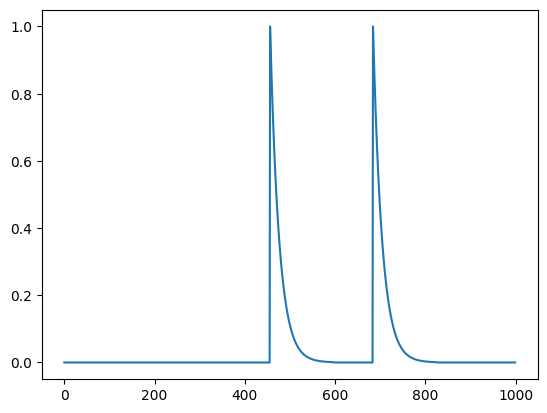

In [6]:
plt.plot(exc_CI[0, :1000])

In [7]:
class IF:
    
    def __init__(self, V_peak, V_reset) -> None:
        self.V_peak = V_peak
        self.V_reset = V_reset
        self.V = V_reset
    
    def update_voltage(self, I_t):
        raise NotImplementedError
    
    def simulate(self, I):
        V_out = [self.V]
        spike_times = []
        T = len(I)

        was_peak = False

        for t in range(T):
            if was_peak:
                V_out.append(self.V)
                was_peak = False
                continue
            self.update_voltage(I[t])
            if self.V >= self.V_peak:
                V_out.append(self.V_peak)
                spike_times.append(t)
                self.V = self.V_reset
                was_peak = True
            else:
                V_out.append(self.V)
        
        return np.array(V_out[1:]), np.array(spike_times)

In [8]:
class QuadraticIF(IF):

    def update_voltage(self, I_t):
        self.V += I_t + self.V ** 2 # wrong

class LeakyIF(IF):

    def update_voltage(self, I_t):
        self.V = self.V + I_t - (self.V - self.V_reset) / R

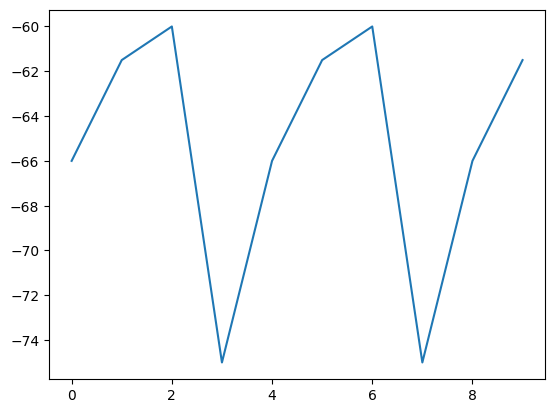

In [57]:
lif = LeakyIF(V_peak = V_peak, V_reset = V_reset)

I_input = 9 * np.ones(sim_time_ms)

V_out, spike_times = lif.simulate(I = I_input)
plt.plot(V_out[:10])

In [18]:
spike_times

array([   2,    6,   10, ..., 4990, 4994, 4998])

In [25]:
def generate_dataset(size):

    I_input = np.zeros((size, N_syn, sim_time_ms))
    V_ouput = np.zeros((size, sim_time_ms))
    spikes_out = np.zeros((size, sim_time_ms))

    for i in tqdm(range(size)):
        np.random.seed(np.random.randint(50, 450))

        CI = np.ones((N_syn, sim_time_ms)) * np.random.randint(1, 80) / 10
        I_input[i] = CI

        lif = LeakyIF(V_peak = V_peak, V_reset = V_reset)
        V_out, spikes = lif.simulate(CI.sum(axis = 0))
        V_ouput[i] = V_out.flatten()
        if len(spikes) > 0:
            spikes_out[i, spikes] = 1
    
    return I_input, V_ouput, spikes_out

In [26]:
class IFDNN(torch.nn.Module):

    def __init__(self, N_syn, win_size):
        super().__init__()
        self.win_size = win_size
        self.conv = torch.nn.Conv1d(in_channels = N_syn, out_channels = 1, kernel_size = self.win_size, padding = "valid")
        self.spike_conv = torch.nn.Conv1d(in_channels = 1, out_channels = 1, kernel_size = 1, padding = "valid")
        self.v_conv = torch.nn.Conv1d(in_channels = 1, out_channels = 1, kernel_size = 1, padding = "valid")

    def forward(self, I_input):
        # Causal padding, so that the kernel uses [... t-1] to predict [t]
        I_input = torch.nn.functional.pad(I_input, (self.win_size - 1, 0))
        out = self.conv(I_input)

        spike_out = self.spike_conv(out)
        spike_out = torch.nn.functional.logsigmoid(spike_out)

        v_out = self.v_conv(out)

        return v_out, spike_out
    
model = IFDNN(N_syn = N_syn, win_size = win_size)

In [27]:
# https://discuss.pytorch.org/t/how-do-i-check-the-number-of-parameters-of-a-model/4325/8
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [28]:
count_parameters(model)

8005

In [29]:
def train(num_epoch, model, device_name, lr, I_train, V_train, spike_times_train, I_test, V_test, spike_times_test):

    device = torch.device(device_name)
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)
    
    I_train = torch.Tensor(I_train).float()
    V_train = torch.tensor(V_train).float()
    spike_times_train = torch.tensor(spike_times_train).long()
    I_test = torch.Tensor(I_test).float()
    V_test = torch.tensor(V_test).float()
    spike_times_test = torch.tensor(spike_times_test).long()

    train_loss_history = []
    test_loss_history = []
    for epoch in range(num_epoch):
        
        model.train(True)
        model.zero_grad()

        V_out, spike_log_probs = model(I_train)
        V_out = V_out[:, 0, :].float()
        spike_log_probs = spike_log_probs[:, 0, :].float()

        loss_spike = 0
        for t in range(sim_time_ms):
            loss_spike += torch.nn.functional.nll_loss(spike_log_probs[:, t], spike_times_train[:, t])

        loss_v = torch.nn.functional.mse_loss(V_out, V_train)
        full_train_loss = loss_spike.float() + loss_v.float()

        full_train_loss.backward()
        optimizer.step()

        model.train(False)
        V_out, spike_log_probs = model(I_test)
        V_out = V_out[:, 0, :].float()
        spike_log_probs = spike_log_probs[:, 0, :].float()

        loss_spike = 0
        for t in range(sim_time_ms):
            loss_spike += torch.nn.functional.nll_loss(spike_log_probs[:, t], spike_times_test[:, t])
        loss_v = torch.nn.functional.mse_loss(V_out, V_test)
        full_test_loss = loss_spike.float() + loss_v.float()

        print(f"[Epoch {epoch}]: train_loss = {full_train_loss.detach().cpu().numpy()}, test_loss = {full_test_loss.detach().cpu().numpy()}")
        train_loss_history.append(full_train_loss.detach().cpu().numpy())
        test_loss_history.append(full_test_loss.detach().cpu().numpy())

    return train_loss_history, test_loss_history

In [41]:
all_train_loss = []
all_test_loss = []

model = IFDNN(N_syn = N_syn, win_size = win_size)
I_input_test, V_ouput_test, spike_times_test = generate_dataset(32)

  0%|          | 0/32 [00:00<?, ?it/s]

100%|██████████| 32/32 [00:00<00:00, 344.04it/s]


In [83]:
for batch_num in range(10):

    I_input_train, V_ouput_train, spike_times_train = generate_dataset(64)

    train_loss_history, test_loss_history = train(
        num_epoch = 15,
        model = model,
        device_name = "cpu",
        lr = 0.0003, # 0.0003
        I_train = I_input_train,
        V_train = V_ouput_train,
        spike_times_train = spike_times_train,
        I_test = I_input_test,
        V_test = V_ouput_test,
        spike_times_test = spike_times_test
    )

    all_train_loss.extend(train_loss_history)
    all_test_loss.extend(test_loss_history)

100%|██████████| 64/64 [00:00<00:00, 293.63it/s]


[Epoch 0]: train_loss = 1224.052978515625, test_loss = 1392.2294921875
[Epoch 1]: train_loss = 1228.23583984375, test_loss = 1381.853271484375
[Epoch 2]: train_loss = 1223.26513671875, test_loss = 1368.70068359375
[Epoch 3]: train_loss = 1220.84033203125, test_loss = 1364.0462646484375
[Epoch 4]: train_loss = 1223.8248291015625, test_loss = 1364.1300048828125
[Epoch 5]: train_loss = 1223.5179443359375, test_loss = 1367.193603515625
[Epoch 6]: train_loss = 1221.01513671875, test_loss = 1373.3912353515625
[Epoch 7]: train_loss = 1220.6009521484375, test_loss = 1379.1146240234375
[Epoch 8]: train_loss = 1222.0313720703125, test_loss = 1379.8077392578125
[Epoch 9]: train_loss = 1222.2332763671875, test_loss = 1375.736083984375
[Epoch 10]: train_loss = 1220.9188232421875, test_loss = 1370.3941650390625
[Epoch 11]: train_loss = 1220.092041015625, test_loss = 1366.6634521484375
[Epoch 12]: train_loss = 1220.60986328125, test_loss = 1365.24609375
[Epoch 13]: train_loss = 1221.215576171875, tes

100%|██████████| 64/64 [00:00<00:00, 291.38it/s]


[Epoch 0]: train_loss = 1490.2261962890625, test_loss = 1364.4776611328125
[Epoch 1]: train_loss = 1478.5633544921875, test_loss = 1371.989013671875
[Epoch 2]: train_loss = 1485.59912109375, test_loss = 1367.606201171875
[Epoch 3]: train_loss = 1480.20556640625, test_loss = 1362.312744140625
[Epoch 4]: train_loss = 1474.7061767578125, test_loss = 1361.8974609375
[Epoch 5]: train_loss = 1475.5205078125, test_loss = 1363.289794921875
[Epoch 6]: train_loss = 1477.647216796875, test_loss = 1362.7750244140625
[Epoch 7]: train_loss = 1475.974365234375, test_loss = 1361.46484375
[Epoch 8]: train_loss = 1472.4288330078125, test_loss = 1361.63623046875
[Epoch 9]: train_loss = 1470.604248046875, test_loss = 1363.3651123046875
[Epoch 10]: train_loss = 1471.103515625, test_loss = 1364.603759765625
[Epoch 11]: train_loss = 1471.5682373046875, test_loss = 1364.0057373046875
[Epoch 12]: train_loss = 1470.2650146484375, test_loss = 1362.3218994140625
[Epoch 13]: train_loss = 1468.0084228515625, test_l

100%|██████████| 64/64 [00:00<00:00, 276.22it/s]


[Epoch 0]: train_loss = 1463.3983154296875, test_loss = 1375.7603759765625
[Epoch 1]: train_loss = 1477.733642578125, test_loss = 1362.57421875
[Epoch 2]: train_loss = 1462.394775390625, test_loss = 1362.242919921875
[Epoch 3]: train_loss = 1464.065673828125, test_loss = 1365.2884521484375
[Epoch 4]: train_loss = 1468.4234619140625, test_loss = 1363.1146240234375
[Epoch 5]: train_loss = 1464.1817626953125, test_loss = 1360.6583251953125
[Epoch 6]: train_loss = 1458.8798828125, test_loss = 1361.6820068359375
[Epoch 7]: train_loss = 1458.1748046875, test_loss = 1364.4671630859375
[Epoch 8]: train_loss = 1460.3104248046875, test_loss = 1365.134033203125
[Epoch 9]: train_loss = 1460.3824462890625, test_loss = 1363.1993408203125
[Epoch 10]: train_loss = 1457.609619140625, test_loss = 1360.94677734375
[Epoch 11]: train_loss = 1454.749755859375, test_loss = 1360.2353515625
[Epoch 12]: train_loss = 1453.967529296875, test_loss = 1360.830078125
[Epoch 13]: train_loss = 1454.679931640625, test_l

100%|██████████| 64/64 [00:00<00:00, 292.99it/s]


[Epoch 0]: train_loss = 1239.7867431640625, test_loss = 1384.832763671875
[Epoch 1]: train_loss = 1238.978271484375, test_loss = 1384.2821044921875
[Epoch 2]: train_loss = 1238.70263671875, test_loss = 1371.747314453125
[Epoch 3]: train_loss = 1234.531982421875, test_loss = 1363.55712890625
[Epoch 4]: train_loss = 1235.5662841796875, test_loss = 1361.615966796875
[Epoch 5]: train_loss = 1237.3204345703125, test_loss = 1362.8814697265625
[Epoch 6]: train_loss = 1235.8653564453125, test_loss = 1367.138916015625
[Epoch 7]: train_loss = 1234.169677734375, test_loss = 1373.308837890625
[Epoch 8]: train_loss = 1234.61669921875, test_loss = 1377.3140869140625
[Epoch 9]: train_loss = 1235.709716796875, test_loss = 1376.349853515625
[Epoch 10]: train_loss = 1235.3582763671875, test_loss = 1371.8743896484375
[Epoch 11]: train_loss = 1234.1937255859375, test_loss = 1367.0985107421875
[Epoch 12]: train_loss = 1233.85302734375, test_loss = 1364.1357421875
[Epoch 13]: train_loss = 1234.46728515625, 

100%|██████████| 64/64 [00:00<00:00, 289.27it/s]


[Epoch 0]: train_loss = 1264.595458984375, test_loss = 1400.3018798828125
[Epoch 1]: train_loss = 1276.3170166015625, test_loss = 1376.08349609375
[Epoch 2]: train_loss = 1264.882080078125, test_loss = 1361.85791015625
[Epoch 3]: train_loss = 1266.0885009765625, test_loss = 1359.551025390625
[Epoch 4]: train_loss = 1270.24609375, test_loss = 1360.513916015625
[Epoch 5]: train_loss = 1267.6336669921875, test_loss = 1365.089599609375
[Epoch 6]: train_loss = 1263.9903564453125, test_loss = 1373.5225830078125
[Epoch 7]: train_loss = 1264.0635986328125, test_loss = 1380.9703369140625
[Epoch 8]: train_loss = 1266.346923828125, test_loss = 1382.1278076171875
[Epoch 9]: train_loss = 1266.7774658203125, test_loss = 1377.3282470703125
[Epoch 10]: train_loss = 1264.976806640625, test_loss = 1370.455810546875
[Epoch 11]: train_loss = 1263.379150390625, test_loss = 1365.014404296875
[Epoch 12]: train_loss = 1263.5970458984375, test_loss = 1362.269287109375
[Epoch 13]: train_loss = 1264.775146484375

100%|██████████| 64/64 [00:00<00:00, 292.02it/s]


[Epoch 0]: train_loss = 1221.3463134765625, test_loss = 1397.976318359375
[Epoch 1]: train_loss = 1234.44677734375, test_loss = 1373.0631103515625
[Epoch 2]: train_loss = 1221.8287353515625, test_loss = 1360.0166015625
[Epoch 3]: train_loss = 1223.5152587890625, test_loss = 1358.426513671875
[Epoch 4]: train_loss = 1228.0272216796875, test_loss = 1359.00830078125
[Epoch 5]: train_loss = 1225.1990966796875, test_loss = 1362.7369384765625
[Epoch 6]: train_loss = 1221.1571044921875, test_loss = 1370.5360107421875
[Epoch 7]: train_loss = 1221.0155029296875, test_loss = 1378.090087890625
[Epoch 8]: train_loss = 1223.4862060546875, test_loss = 1379.9146728515625
[Epoch 9]: train_loss = 1224.254638671875, test_loss = 1375.741455078125
[Epoch 10]: train_loss = 1222.493896484375, test_loss = 1369.157958984375
[Epoch 11]: train_loss = 1220.58984375, test_loss = 1363.6988525390625
[Epoch 12]: train_loss = 1220.4923095703125, test_loss = 1360.7958984375
[Epoch 13]: train_loss = 1221.7252197265625,

100%|██████████| 64/64 [00:00<00:00, 267.57it/s]


[Epoch 0]: train_loss = 2189.203125, test_loss = 1363.34375
[Epoch 1]: train_loss = 2130.411376953125, test_loss = 1394.721435546875
[Epoch 2]: train_loss = 2114.648193359375, test_loss = 1435.22998046875
[Epoch 3]: train_loss = 2125.4326171875, test_loss = 1458.0382080078125
[Epoch 4]: train_loss = 2135.460693359375, test_loss = 1456.2330322265625
[Epoch 5]: train_loss = 2132.677001953125, test_loss = 1438.5062255859375
[Epoch 6]: train_loss = 2121.589599609375, test_loss = 1415.1700439453125
[Epoch 7]: train_loss = 2110.08154296875, test_loss = 1393.74560546875
[Epoch 8]: train_loss = 2103.423828125, test_loss = 1378.248779296875
[Epoch 9]: train_loss = 2102.8486328125, test_loss = 1369.3162841796875
[Epoch 10]: train_loss = 2105.755126953125, test_loss = 1365.458740234375
[Epoch 11]: train_loss = 2107.86328125, test_loss = 1364.99755859375
[Epoch 12]: train_loss = 2106.54248046875, test_loss = 1367.2423095703125
[Epoch 13]: train_loss = 2102.01904296875, test_loss = 1372.30615234375

100%|██████████| 64/64 [00:00<00:00, 291.81it/s]


[Epoch 0]: train_loss = 1846.295654296875, test_loss = 1357.8480224609375
[Epoch 1]: train_loss = 1847.76513671875, test_loss = 1359.23193359375
[Epoch 2]: train_loss = 1843.02783203125, test_loss = 1366.800537109375
[Epoch 3]: train_loss = 1838.4931640625, test_loss = 1376.6251220703125
[Epoch 4]: train_loss = 1839.7109375, test_loss = 1377.964599609375
[Epoch 5]: train_loss = 1839.02685546875, test_loss = 1371.8331298828125
[Epoch 6]: train_loss = 1835.482177734375, test_loss = 1364.8187255859375
[Epoch 7]: train_loss = 1833.326171875, test_loss = 1360.834716796875
[Epoch 8]: train_loss = 1833.285400390625, test_loss = 1359.911376953125
[Epoch 9]: train_loss = 1832.667236328125, test_loss = 1361.1788330078125
[Epoch 10]: train_loss = 1830.4052734375, test_loss = 1364.47119140625
[Epoch 11]: train_loss = 1828.117431640625, test_loss = 1368.829833984375
[Epoch 12]: train_loss = 1827.0972900390625, test_loss = 1371.80810546875
[Epoch 13]: train_loss = 1826.5416259765625, test_loss = 137

100%|██████████| 64/64 [00:00<00:00, 287.30it/s]


[Epoch 0]: train_loss = 1319.730224609375, test_loss = 1357.1409912109375
[Epoch 1]: train_loss = 1282.9794921875, test_loss = 1374.0162353515625
[Epoch 2]: train_loss = 1281.208251953125, test_loss = 1395.0838623046875
[Epoch 3]: train_loss = 1292.91552734375, test_loss = 1399.3348388671875
[Epoch 4]: train_loss = 1295.7227783203125, test_loss = 1389.793212890625
[Epoch 5]: train_loss = 1289.557373046875, test_loss = 1375.9111328125
[Epoch 6]: train_loss = 1281.9857177734375, test_loss = 1364.566650390625
[Epoch 7]: train_loss = 1278.4630126953125, test_loss = 1358.5072021484375
[Epoch 8]: train_loss = 1280.0616455078125, test_loss = 1356.68798828125
[Epoch 9]: train_loss = 1283.877685546875, test_loss = 1356.498046875
[Epoch 10]: train_loss = 1286.0479736328125, test_loss = 1356.4964599609375
[Epoch 11]: train_loss = 1285.0367431640625, test_loss = 1357.0665283203125
[Epoch 12]: train_loss = 1282.0191650390625, test_loss = 1359.2698974609375
[Epoch 13]: train_loss = 1279.212280273437

100%|██████████| 64/64 [00:00<00:00, 286.20it/s]


[Epoch 0]: train_loss = 1277.927001953125, test_loss = 1356.5828857421875
[Epoch 1]: train_loss = 1287.0545654296875, test_loss = 1358.50439453125
[Epoch 2]: train_loss = 1277.921875, test_loss = 1370.32666015625
[Epoch 3]: train_loss = 1278.3447265625, test_loss = 1378.22021484375
[Epoch 4]: train_loss = 1281.87451171875, test_loss = 1374.07373046875
[Epoch 5]: train_loss = 1279.845703125, test_loss = 1365.54248046875
[Epoch 6]: train_loss = 1276.8924560546875, test_loss = 1359.3983154296875
[Epoch 7]: train_loss = 1277.11376953125, test_loss = 1357.146728515625
[Epoch 8]: train_loss = 1279.0037841796875, test_loss = 1357.0201416015625
[Epoch 9]: train_loss = 1279.1121826171875, test_loss = 1358.40478515625
[Epoch 10]: train_loss = 1277.5, test_loss = 1361.7845458984375
[Epoch 11]: train_loss = 1276.406982421875, test_loss = 1366.362060546875
[Epoch 12]: train_loss = 1276.909423828125, test_loss = 1369.5506591796875
[Epoch 13]: train_loss = 1277.85009765625, test_loss = 1369.368164062

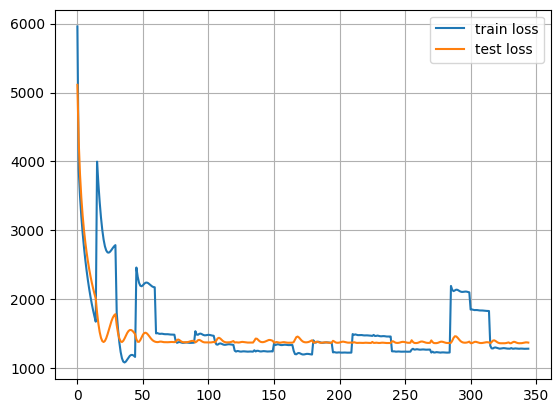

In [84]:
plt.plot(all_train_loss, label = "train loss")
plt.plot(all_test_loss, label = "test loss")
plt.grid()
plt.legend()

In [85]:
conv_params = list(model.parameters())[0].detach().numpy()[0]
conv_params.shape

(100, 80)

In [86]:
np.median(conv_params)

-0.004044835

In [87]:
conv_params

array([[-6.30164705e-03,  7.44867697e-03, -8.54915008e-03, ...,
        -1.22973323e-02, -7.35825486e-03, -7.91257061e-03],
       [ 2.46312609e-03, -7.42961746e-03,  6.13595033e-03, ...,
        -1.19583067e-02, -2.23779716e-02, -1.56608857e-02],
       [-1.85286603e-03, -4.35153395e-03,  6.42798987e-05, ...,
        -2.13396698e-02, -2.33710185e-02, -1.93343330e-02],
       ...,
       [ 1.07513955e-02, -4.92136180e-03, -9.18770768e-03, ...,
        -6.41723396e-03, -3.31106666e-03, -2.33383309e-02],
       [-8.89897253e-03, -1.04154618e-02,  1.60029519e-03, ...,
        -3.05081648e-03, -4.00841236e-03, -2.66346093e-02],
       [ 3.59310885e-03, -2.56847008e-03,  2.96165748e-03, ...,
        -4.65824176e-03, -9.06636752e-03, -2.62933392e-02]], dtype=float32)

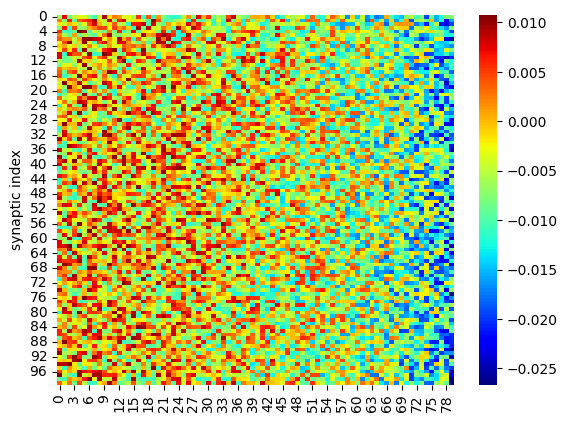

In [88]:
import seaborn as sns
#plt.imshow(conv_params, cmap = 'jet')
sns.heatmap(conv_params, cmap = "jet")
plt.ylabel("synaptic index");

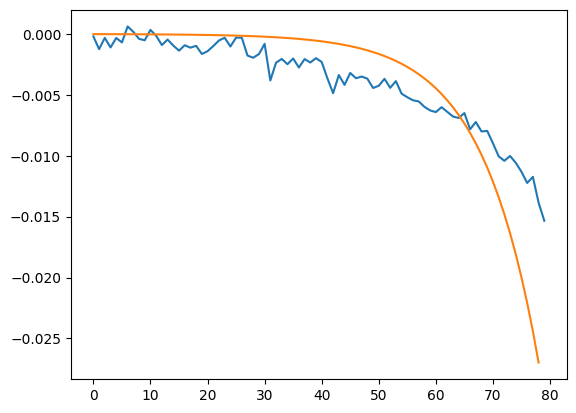

In [117]:
plt.plot(conv_params.mean(axis = 0))
plt.plot(-np.exp(np.arange(1, 80) / 10) * 1e-5)